In [17]:
from fy4a import AGRI_L1
import numpy
import matplotlib.pyplot as plt

## 读取原始数据

In [18]:
hdf_path = '/disk2/workspace/20230414/FY4A_AGRI_20220624_00_08/L1/FY4A-_AGRI--_N_DISK_1047E_L1-_FDI-_MULT_NOM_20220624040000_20220624041459_1000M_V0001.HDF'

In [10]:
# 可视化原始圆盘影像
import h5py
def display_original_DF(hdf_path):
    f = h5py.File(hdf_path, 'r')
    dset = f['NOMChannel01'] # DN值
    d_array = numpy.array(dset)
    dset = f['CALChannel01'] # DN值查找表
    c_array = numpy.array(dset)
    dc_array = numpy.copy(d_array)
    dc_array[dc_array>=65534] = 0
    toa_array = c_array[dc_array] # DN值转成TOA真实值
    toa_array[toa_array==0] = numpy.NaN
    f.close()
    plt.imshow(toa_array, interpolation=None)
    plt.colorbar()

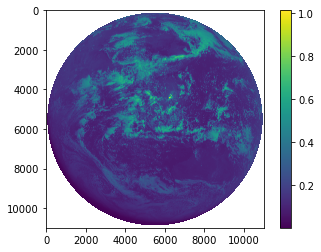

In [11]:
display_original_DF(hdf_path)

## 选择区域投影裁切

In [19]:
def proj_clip_ex(hdf_path, geo_desc, band_name):
    fy4a_file = AGRI_L1(hdf_path, geo_desc)
    reflectance = fy4a_file.extract(band_name)
    return reflectance

In [20]:
geo_desc = [-60, 60, 45, 165, 0.01]  # 顺序为南、北、西、东、分辨率，即[lat_s, lat_n, lon_w, lon_e, resolution] 中心104.7°
Channel01_reflectance = proj_clip_ex(hdf_path, geo_desc, 'Channel01')
s_array = numpy.array(Channel01_reflectance)

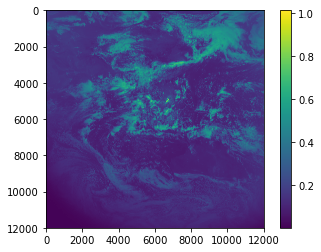

In [21]:
# 可视化裁切投影区域影像
plt.imshow(s_array, interpolation=None)
plt.colorbar()